# FluoStar Data Analysis

**Important**: Conect enviroment to the drive.


In [ ]:
# Documents paths

# Excell with measurements
path = '/content/drive/MyDrive/Marta/FluoStar/Complete_Cenpk_BY_fluostar_10 03 23/Fluorstar_marta_10 3 23.xlsx'

# .txt with each sample information, example row: Sample X1,Condition,Strain
layoutpath = '/content/drive/MyDrive/Marta/FluoStar/Complete_Cenpk_BY_fluostar_10 03 23/Layout.txt'

## Data Analysis 

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore') # To ignore some warnings and have a clean output
from plotnine import *
from plotnine.data import *

In [ ]:
# read the data excel file and create dataframe
df = pd.read_excel(path)

# Transpose the dataset for easier edit adn delete unimportant data 
df2 = df.iloc[10:].T

In [ ]:
# This code calculates the rows that include the 485 data (gfp), the other rows include 600 data (od)
n = 0
for i in df2.iloc[:,0]:
  if "485" in i:
    n = n+1
imp_data = n + 2

Create gfp data dataframes, calculate mean of replicates and standard deviation

In [ ]:
# Create gfp data dataframe, cut first two columns and Transpose again
df3 = df2.iloc [:imp_data,2:].T

# Get array of Sample names to loop over
Samples = pd.unique(df3.iloc [:,1])

mean = []
sds = []

#This loop will walk through every Sample name (f.e. "Sample X1"), extract mean of replicates and standard deviation
for s in Samples:

  # Save data of replicates
  data_s= df3[df3.iloc[:,1] == s]

  #Calculate average of each Sample
  mean.append(np.mean(data_s, axis = 0))

  #Calculate standard deviation for each Sample
  sds.append(data_s.std())

# Generate final dataframe
df_gfp_sd = pd.DataFrame(sds).T
df_gfp_sd.columns = Samples
df_gfp = pd.DataFrame(mean).T
df_gfp.columns = Samples

#Change df so now every value is labeled with the corresponding sample
dfg_gfp = pd.melt(df_gfp)
dfg_gfp.columns = ['Sample', 'gfp']
dfg_gfp_sd = pd.melt(df_gfp_sd)
dfg_gfp_sd.columns = ['Sample', 'sd']

The same for OD

In [ ]:
# Cut the dataframe to only have od raw data, cut first two columns and Transpose again
titles = df2.iloc[:2,2:].T  # to have first two columns with sample names
od = titles.join(df2.iloc[ imp_data:,2:].T)

Samples = pd.unique(od.iloc [:,1])

mean = []
sds = []
#This loop will walk through every Sample name (f.e. "Sample X1"), extract mean of replicates and standard deviation
for s in Samples:
  data_s= od[od.iloc[:,1] == s]

  #Calculate average of each Sample
  mean.append(np.mean(data_s, axis = 0))

  #Calculate standard deviation for each Sample
  sds.append(data_s.std())

# Generate final dataframe
df_od_sd = pd.DataFrame(sds).T
df_od_sd.columns = Samples
df_od = pd.DataFrame(mean).T
df_od.columns = Samples

#Change df so now every value is labeled with the corresponding sample
dfg_od = pd.melt(df_od)
dfg_od.columns = ['Sample', 'od']
dfg_od_sd = pd.melt(df_od_sd)
dfg_od_sd.columns = ['Sample', 'od']

Get labels from Lauout.txt and label data

In [ ]:
#Now we have every timepoint labeled with its sample and separated by GFP and OD, we add conditions and proper name of sample

# Create dataframe with labels data
layouts = pd.read_csv(layoutpath, header= None)
layouts.columns = ['Sample', 'Condition', 'Strain'] 

final_data = pd.DataFrame()
maxGFP= pd.DataFrame()

# Loop over samples
for s in Samples:
  #For each sample it will put the proper Strain, Condition and create the timelapse column in final_data
  new_df = dfg_gfp[dfg_gfp['Sample'] == s].join(dfg_od[dfg_od['Sample'] == s]['od']).join(dfg_gfp_sd[dfg_gfp_sd['Sample'] == s]['sd'])

  lo = layouts[layouts['Sample'] == s]
  condition = lo['Condition'].values[0]
  strain = lo['Strain'].values[0]

  
  new_df = new_df.assign(Condition = lambda dataframe: new_df['Sample'].map(lambda Sample: condition))
  new_df = new_df.assign(Strain = lambda dataframe: new_df['Sample'].map(lambda Sample: strain))
  
  timelapse = (np.arange(len(new_df.iloc[:,1])))

  new_df['Timelapse'] = (timelapse)

  # Find index of maximum and delete the following data
  max_val = new_df['gfp'].idxmax() - new_df.index[0] + 1
                
  short_df = new_df.iloc[0:max_val,:]

  final_data = final_data.append(short_df)

  #It will look for max intensity of gfp for each sample an save it into a maxGFP dataframe
  if len(new_df[new_df['gfp'] == max(new_df['gfp'])].iloc[:,1]) > 0 :
    maxGFP = maxGFP.append(new_df[new_df['gfp'] == max(new_df['gfp'])])
  else :
    maxGFP = maxGFP.append(new_df[new_df['gfp'] == max(new_df['gfp'])])


## Download Final Data 

In [ ]:
final_data.to_csv(r'/content/drive/MyDrive/Marta/FluoStar/Complete_Cenpk_BY_fluostar_10 03 23/processed_data.csv', index=False)

## Plots

In [ ]:
# Drive folder to save plots

folderpath = '/content/drive/MyDrive/Marta/FluoStar/Complete_Cenpk_BY_fluostar_10 03 23'

### For different strains in same condition

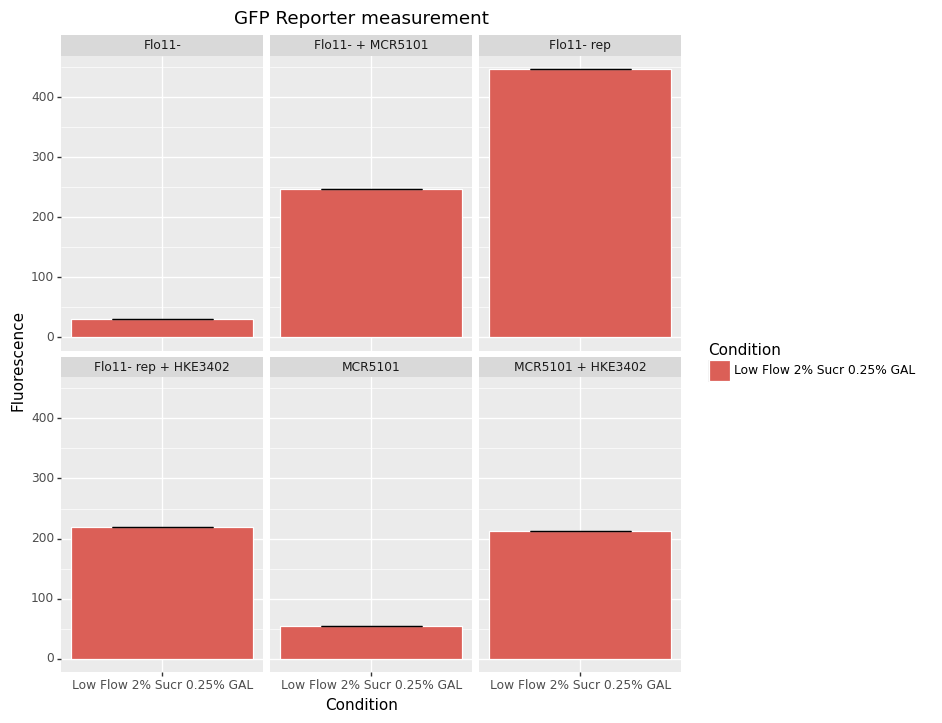

<ggplot: (8785623555688)>

In [ ]:
# Strain separated barplots of maximum GFP 
# Change strain paraemeter to plot the desired strain or strains like ['strain1', 'strain2', 'strain3']
strain = ['Flo11-', 'Flo11- rep', 'Flo11- + MCR5101', 'Flo11- rep + HKE3402', 'MCR5101', 'MCR5101 + HKE3402']

myPlot = (

    ggplot(maxGFP[maxGFP['Strain'].isin(strain)])
    + geom_bar(aes(x='Condition', y ='gfp', fill = 'Condition'), stat = 'identity', color = 'White', position = "dodge") 
    + geom_errorbar(aes(x = 'Condition', ymin = 'gfp-sd', ymax = 'gfp+sd'))
    + labs(title="GFP Reporter measurement", y='Fluorescence')
    + facet_wrap(['Strain'])
    + theme(figure_size=(8, 8))
)

myPlot.save(f'{folderpath}/MaxFluorescence_strain.png', dpi=600)

myPlot

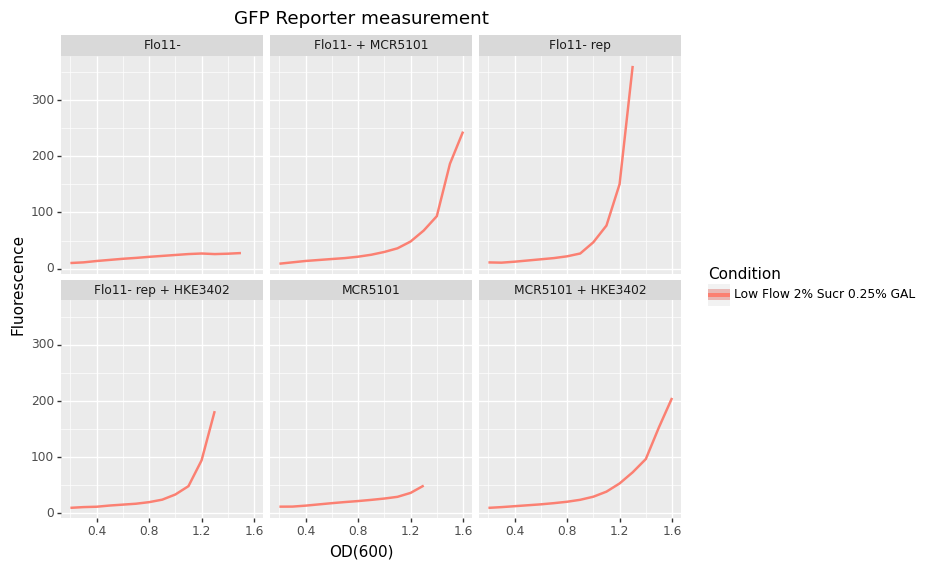

<ggplot: (8785621134946)>

In [ ]:
# Strain separated linegraphs of GFP vs OD(600)
# Change strain paraemeter to plot the desired strain or strains like ['strain1', 'strain2', 'strain3']
strain = ['Flo11-', 'Flo11- rep', 'Flo11- + MCR5101', 'Flo11- rep + HKE3402', 'MCR5101', 'MCR5101 + HKE3402']

myPlot = (
    ggplot(final_data[final_data['Strain'].isin(strain)])
    + aes(x='od', y ='gfp', fill = 'Condition') 
    + geom_smooth(span=.2, se=True, color='#fb8072')
    + labs(title="GFP Reporter measurement",x = 'OD(600)', y='Fluorescence')
    + facet_wrap(['Strain'])
    + theme(figure_size=(8, 6))
)

myPlot.save(f'{folderpath}/Fluorescence_OD600.png', dpi=600)

myPlot

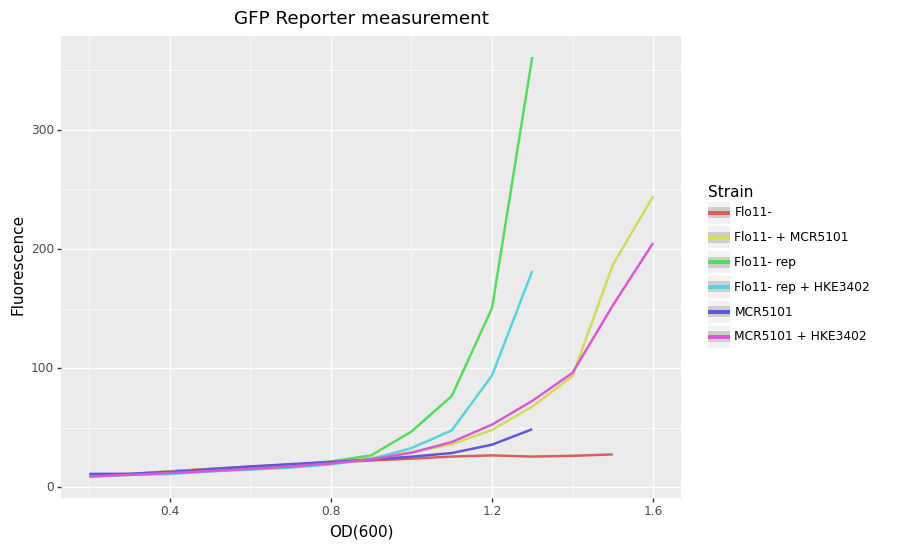

<ggplot: (8785623413745)>

In [ ]:
# Linegraph of GFP vs OD(600) of strains
# Change strain paraemeter to plot the desired strain or strains like ['strain1', 'strain2', 'strain3']
strain = ['Flo11-', 'Flo11- rep', 'Flo11- + MCR5101', 'Flo11- rep + HKE3402', 'MCR5101', 'MCR5101 + HKE3402']

myPlot = (
    ggplot(final_data[final_data['Strain'].isin(strain)])
    + aes(x='od', y ='gfp', color = 'Strain') 
    + geom_smooth(span=.2, se=True)
    + labs(title="GFP Reporter measurement",x = 'OD(600)', y='Fluorescence')
    + theme(figure_size=(8, 6))
)

#myPlot.save(f'{folderpath}/Join_Fluorescence_OD600.png', dpi=600)

myPlot